### 4 - Displaying Core Data and Deriving a Poro Perm Relationship

Created By: Andy McDonald
<br><br>
The following short tutorial illustrates the process of loading in core data from a CSV file, creating poro-perm crossplots, and deriving a poro-perm relationship using numpy.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
core_data = pd.read_csv("Data/CoreData.csv")

In [3]:
core_data.head()

,SAMPLE,DEPTH,SW,SO,CKH,CPOR,CGD
0,2DS,10715.70115,21.850474,52.400205,156.170,24.95,2.661
1,3VDS,10716.57075,29.665587,48.126653,77.342,23.45,2.658
2,4DS,10716.89685,24.344271,47.470879,196.344,25.28,2.653
3,5VDS,10717.11425,25.063665,52.153449,147.086,23.33,2.653
4,7VDS,10718.63605,24.756409,52.020974,144.810,24.07,2.655


In [4]:
core_data.describe()

,DEPTH,SW,SO,CKH,CPOR,CGD
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,10761.782905,35.509717,40.728041,114.365102,19.677500,2.661935
std,28.333169,12.124610,11.880550,116.074693,4.366594,0.015253
min,10715.701150,21.489047,0.000000,0.045000,2.360000,2.647000
25%,10738.079762,26.733086,36.095689,36.319000,18.607500,2.655000
50%,10760.648600,31.393546,42.411968,96.861500,20.330000,2.657000
75%,10783.054388,41.666675,47.502606,151.569250,22.137500,2.663000
max,10811.411500,77.868532,99.226071,788.070000,25.280000,2.758000


We can make a quick scatter plot by:

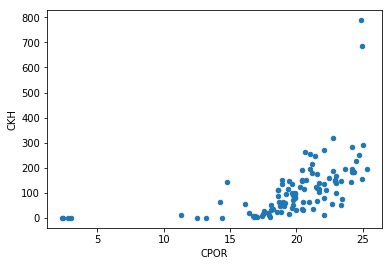

In [5]:
core_data.plot(kind="scatter", x="CPOR", y="CKH")

There is one main problem with previous plot. Poro-perm data is normally presented on semilog scale, where the y-axis is logarithmic and the x-axis set to linear. We can change this by using the yscale('log') method.

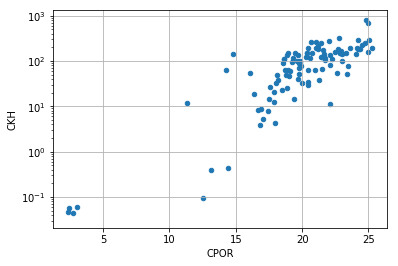

In [6]:
core_data.plot(kind="scatter", x="CPOR", y="CKH")
plt.yscale('log')
plt.grid(True)

We can further refine the scatter plot by removing the scientific notation on the y-axis.

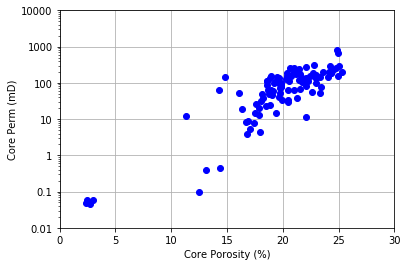

In [7]:
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots()

ax.axis([0, 30, 0.01, 10000])
ax.plot(core_data['CPOR'], core_data['CKH'], 'bo')
ax.set_yscale('log')
ax.grid(True)
ax.set_ylabel('Core Perm (mD)')
ax.set_xlabel('Core Porosity (%)')

#Format the axes so that they show whole numbers
for axis in [ax.yaxis, ax.xaxis]:
    formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
    axis.set_major_formatter(formatter)

We can derive a linear regression by using the polyfit function from numpy. As we are working with a semi-log plot, we need to calculate log base 10 of the core permeability.

In [8]:
x = np.polyfit(core_data['CPOR'], np.log10(core_data['CKH']), 1)

In [9]:
x

array([ 0.16911398, -1.61346487])

The result of the regression is: $10^{(0.16911398  * CPOR - 1.61346487)}$

Using the code from the previous plot, we can now add a new line with our x-axis set to porosity and our y-axis set to an equation. Note that we have to use the equation above to reverse the log base 10 function used when deriving the function.

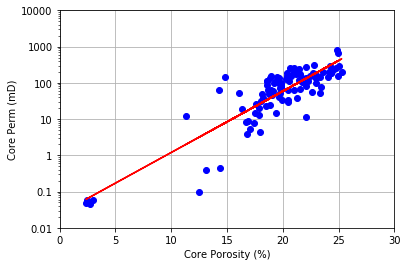

In [10]:
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots()

ax.axis([0, 30, 0.01, 10000])
ax.semilogy(core_data['CPOR'], core_data['CKH'], 'bo')

ax.grid(True)
ax.set_ylabel('Core Perm (mD)')
ax.set_xlabel('Core Porosity (%)')

ax.semilogy(core_data['CPOR'], 10**(x[0] * core_data['CPOR'] + x[1]), 'r-')


#Format the axes so that they show whole numbers
for axis in [ax.yaxis, ax.xaxis]:
    formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
    axis.set_major_formatter(formatter)
    


Our next step is to calculate a predicted permeability using our new equation and add it as a new column in the pandas dataframe.

In [11]:
core_data["PRED_PERM"] = 10**(x[0] * core_data['CPOR'] + x[1])

In [12]:
core_data.describe()

,DEPTH,SW,SO,CKH,CPOR,CGD,PRED_PERM
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,10761.782905,35.509717,40.728041,114.365102,19.677500,2.661935,106.406799
std,28.333169,12.124610,11.880550,116.074693,4.366594,0.015253,108.960627
min,10715.701150,21.489047,0.000000,0.045000,2.360000,2.647000,0.061044
25%,10738.079762,26.733086,36.095689,36.319000,18.607500,2.655000,34.145923
50%,10760.648600,31.393546,42.411968,96.861500,20.330000,2.657000,66.788949
75%,10783.054388,41.666675,47.502606,151.569250,22.137500,2.663000,135.011588
max,10811.411500,77.868532,99.226071,788.070000,25.280000,2.758000,458.919473


We can then make a quick plot of our prediction vs the original measurement. To get an idea of how well the prediction did, we can add a 1 to 1 line to aid the visualisation.

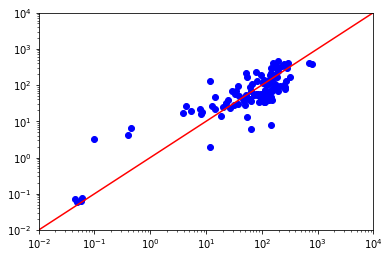

In [13]:
fig, ax = plt.subplots()

ax.axis([0.01, 10000, 0.01, 10000])
ax.loglog(core_data['CKH'], core_data['PRED_PERM'], 'bo')
ax.loglog([0.01, 10000], [0.01, 10000], 'r-')